# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

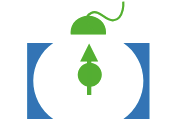

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
# TODO: Have a default NN and then give user the ability to supply a model or a function
# With log p terms: 0.0.9984141684258416
# Without log p terms: 0.999796307373522
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation
initial_params = {
    "POVM": [0.1, -3 * jnp.pi/2]
}
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=None,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=initial_params,
    num_time_steps=5,
    mode="lookup",
    goal="purity",
    optimizer="adam",
    max_iter=1000,
    convergence_threshold=1e-6,
    learning_rate=0.1,
    type="density",
)

In [6]:
result

FgResult(optimized_rnn_parameters=[[[Array([-0.60183224, -3.14921322], dtype=float64)], [Array([-2.39923276, -0.29054238], dtype=float64)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)]], [[Array([-1.22138811, -1.66726936], dtype=float64)], [Array([-2.39923276, -0.29054238], dtype=float64)], [Array([-0.4773859 , -2.20922398], dtype=float64)], [Array([ 2.2958313 , -0.29402536], dtype=float64)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Array([0., 0.], dtype=float32)], [Arr

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_purity)

0.9781386947333507


In [9]:
from feedback_grape.utils.purity import purity

print("initial purity:", purity(rho=rho_cav))
print("Final purity:", purity(rho=result.final_state))

initial purity: 0.20000208604889932
Final purity: 0.9781386947333507


In [10]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.09735403621715237
0.9026459637828469


In [11]:
# TODO: make this the same type for all
result.arr_of_povm_params

[[[0.1, -4.71238898038469]],
 [[-0.6018322435851956, -3.149213215479032]],
 [[-1.2213881141248157, -1.6672693601505735]],
 [[-0.27324763928761225, -3.7730407750308586]],
 [[-0.4293839000315703, -3.4388885349219827]]]

### Check stash for replacement of dict implementation

In [12]:
from feedback_grape.fgrape import povm

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))
for i in range(time_steps):
    params = result.arr_of_povm_params[i][0]
    rho, _, _ = povm(rho, povm_measure_operator, params)
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
purity of rho after time step 0 0.22906358179156958
purity of rho after time step 1 0.3824264733521343
purity of rho after time step 2 0.6531758267553153
purity of rho after time step 3 0.8850764932090641
purity of rho after time step 4 0.9781391388850346


In [13]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 9.07175789e-01+0.j -2.10715758e-01+0.j -1.03968433e-01+0.j
  -7.69292764e-02+0.j -5.75453400e-02+0.j -4.22529687e-02+0.j
  -3.43622870e-02+0.j -2.65852312e-02+0.j -2.79617349e-02+0.j
  -2.39253159e-02+0.j -2.74168755e-02+0.j -3.07168370e-02+0.j
  -2.70338411e-02+0.j -2.33526942e-02+0.j -1.82940886e-02+0.j
  -1.41070879e-02+0.j -1.05250611e-02+0.j -1.11232072e-02+0.j
  -1.32729739e-02+0.j -1.50560562e-02+0.j -1.46010026e-02+0.j
  -1.10032844e-02+0.j -3.67674239e-03+0.j -8.10721026e-05+0.j
  -3.04329471e-03+0.j -6.26923352e-04+0.j -2.71035668e-03+0.j
  -8.03731105e-03+0.j -7.37130480e-03+0.j -5.79967028e-03+0.j]
 [-2.10715758e-01+0.j  5.18056746e-02+0.j  2.41671188e-02+0.j
   1.74297467e-02+0.j  1.31064034e-02+0.j  9.68657199e-03+0.j
   7.60180664e-03+0.j  5.95424423e-03+0.j  6.13271495e-03+0.j
   5.73314741e-03+0.j  6.27529812e-03+0.j  6.70648417e-03+0.j
   6.04338862e-03+0.j  5.16482973e-03+0.j  3.96894838e-03+0.j
   3.12115505e-03+0.j  2

In [14]:
print("Final state from solver:", result.final_state)

Final state from solver: [[ 9.07175627e-01+0.j -2.10715249e-01+0.j -1.03968929e-01+0.j
  -7.69292728e-02+0.j -5.75454473e-02+0.j -4.22530078e-02+0.j
  -3.43623938e-02+0.j -2.65851342e-02+0.j -2.79616837e-02+0.j
  -2.39253467e-02+0.j -2.74169901e-02+0.j -3.07169529e-02+0.j
  -2.70339587e-02+0.j -2.33528892e-02+0.j -1.82940278e-02+0.j
  -1.41069859e-02+0.j -1.05250326e-02+0.j -1.11232415e-02+0.j
  -1.32730192e-02+0.j -1.50561426e-02+0.j -1.46011572e-02+0.j
  -1.10033262e-02+0.j -3.67663068e-03+0.j -8.07527116e-05+0.j
  -3.04298561e-03+0.j -6.26555282e-04+0.j -2.71014478e-03+0.j
  -8.03718292e-03+0.j -7.37124590e-03+0.j -5.79961475e-03+0.j]
 [-2.10715249e-01+0.j  5.18054486e-02+0.j  2.41671896e-02+0.j
   1.74297094e-02+0.j  1.31063999e-02+0.j  9.68656165e-03+0.j
   7.60181569e-03+0.j  5.95420712e-03+0.j  6.13268927e-03+0.j
   5.73314986e-03+0.j  6.27530885e-03+0.j  6.70648419e-03+0.j
   6.04339485e-03+0.j  5.16485524e-03+0.j  3.96892174e-03+0.j
   3.12112632e-03+0.j  2.50895629e-03+0.j  2

In [15]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [16]:
import jax.numpy as jnp
import tree
import jax
initial_params = {
    "POVM": [0.1, 0.2],
    "test":[0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1]
}
# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [17]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
